Anomalies detected using kNN with threshold distance > 66.89999999999995:
     from   to    cost  community  Anomaly
15     92  243   667.3          1     True
18    203   80  1071.1          1     True
23     57   55   925.2          1     True
39    227  167  1425.7          3     True
57    302  104  1093.8          3     True
75     98   31     3.2          5     True
76     70  255  1308.8          5     True
87    215  111  2685.8          5     True
88    111  116  1194.2          5     True
89     86  214  2712.1          5     True
92     27   98     7.7          5     True
98    256    1  1149.5          5     True
120   128  131   672.4          6     True
142   115   86  1228.5          7     True
317   222   79  1270.1         25     True
318    79   90   981.4         25     True
322    81  204  1023.1         25     True
David-Boldin Index: 1.35
Silhouette Score: -0.71


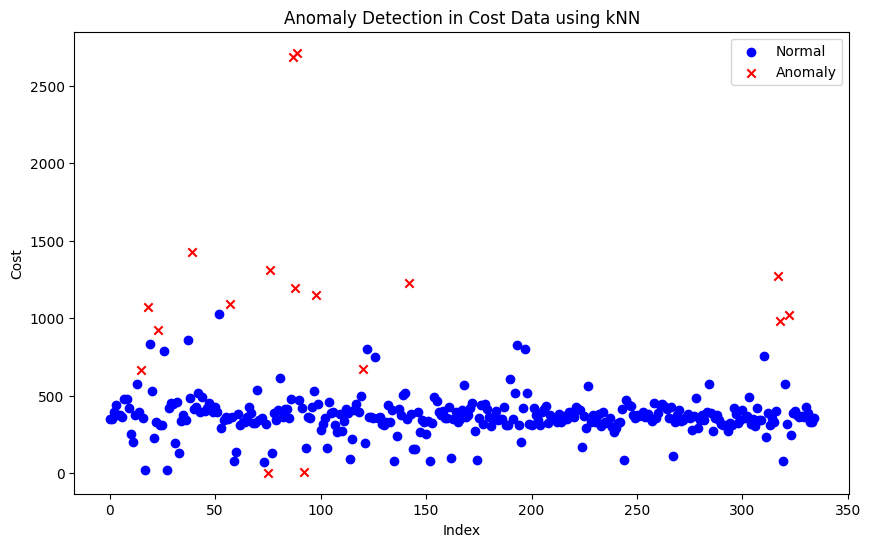

In [1]:
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


df = pd.read_csv('../../data/PEMS04/PEMS04.csv')


df.dropna(inplace=True)


G = nx.from_pandas_edgelist(df, 'from', 'to', ['cost'], create_using=nx.DiGraph)


partition = community_louvain.best_partition(G.to_undirected())


for u, v, d in G.edges(data=True):
    d['community'] = partition[u]


data = []

for community in set(partition.values()):
    edges = [(u, v, d['cost']) for u, v, d in G.edges(data=True) if d['community'] == community]
    costs = [cost for _, _, cost in edges]

    if len(costs) < 2:  
        continue

    for u, v, cost in edges:
        data.append({'from': u, 'to': v, 'cost': cost, 'community': community})


df_anomalies = pd.DataFrame(data)


k = 5  
nbrs = NearestNeighbors(n_neighbors=k).fit(df_anomalies[['cost']])
distances, _ = nbrs.kneighbors(df_anomalies[['cost']])


kth_distances = distances[:, k-1]


distance_threshold = np.percentile(kth_distances, 95)  
df_anomalies['Anomaly'] = kth_distances > distance_threshold


print(f"Anomalies detected using kNN with threshold distance > {distance_threshold}:")
print(df_anomalies[df_anomalies['Anomaly']])


total_z_mean = np.mean(np.abs(zscore(df_anomalies['cost'])))
anomalies_z_mean = np.mean(np.abs(zscore(df_anomalies[df_anomalies['Anomaly']]['cost'])))
david_boldin_index = anomalies_z_mean / total_z_mean

print(f'David-Boldin Index: {david_boldin_index:.2f}')


node_costs_labels = pd.DataFrame([(d['cost'], partition[u]) for u, v, d in G.edges(data=True)], columns=['cost', 'community'])

from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(node_costs_labels[['cost']], node_costs_labels['community'])
print(f'Silhouette Score: {silhouette_avg:.2f}')


plt.figure(figsize=(10, 6))
normal_points = df_anomalies[df_anomalies['Anomaly'] == False]
anomalies_points = df_anomalies[df_anomalies['Anomaly'] == True]
plt.scatter(normal_points.index, normal_points['cost'], c='blue', marker='o', label='Normal')
plt.scatter(anomalies_points.index, anomalies_points['cost'], c='red', marker='x', label='Anomaly')
plt.xlabel('Index')
plt.ylabel('Cost')
plt.title('Anomaly Detection in Cost Data using kNN')
plt.legend()
plt.show()
